/tmp/ipython-input-3141752903.py:135: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  return _scipy_sph_harm(m, l, theta, phi)


KeyboardInterrupt: 

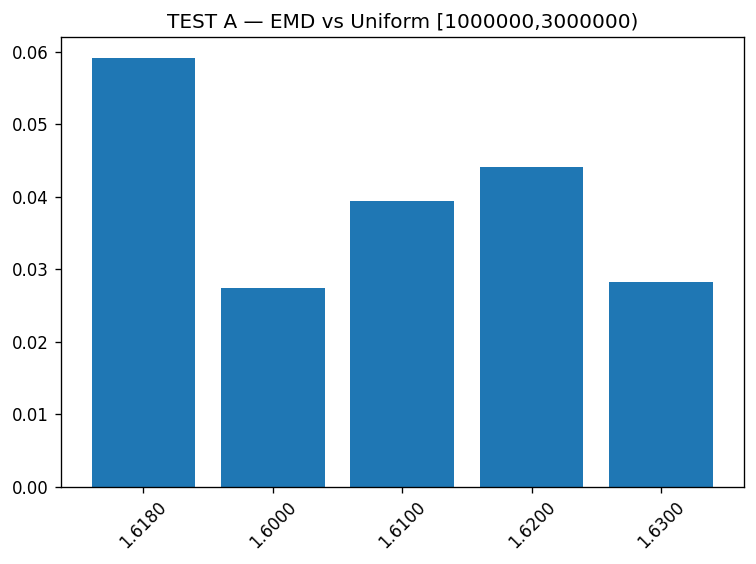

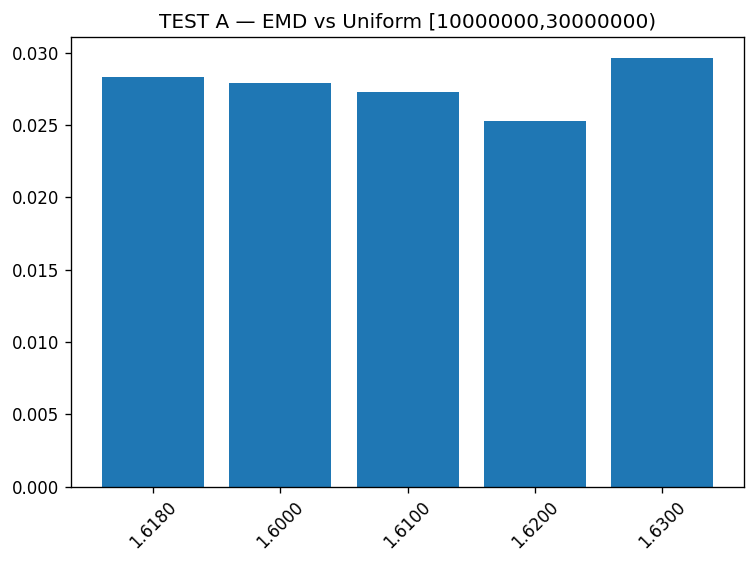

In [1]:
# === PRIME φ–4π BIG TEST (Colab-clean: no pip, no upgrades) ===
import os, math, json, zipfile, time, csv
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

# Try SciPy, but provide safe fallbacks if some pieces are missing
try:
    import scipy
    from scipy.special import sph_harm as _scipy_sph_harm, lpmv
except Exception:
    scipy = None
    _scipy_sph_harm = None
    lpmv = None

# ------------------------- reproducibility & IO -------------------------
SEED = 123456789
rng = default_rng(SEED)
BASE_DIR = "prime_phi_tests"
os.makedirs(BASE_DIR, exist_ok=True)

def write_csv(path, rows, header=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        if header:
            f.write(",".join(header) + "\n")
        for r in rows:
            f.write(",".join(str(x) for x in r) + "\n")

def zip_dir(dir_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
        for root, _, files in os.walk(dir_path):
            for fn in files:
                fp = os.path.join(root, fn)
                z.write(fp, arcname=os.path.relpath(fp, start=dir_path))

# ------------------------- primes (sympy only) -------------------------
# Use sympy for prime enumeration; most Colab builds already include it.
# We import lazily to avoid import-time noise.
def primes_in_window(lo, hi):
    from sympy import primerange  # imported here to avoid global import issues
    return np.fromiter(primerange(int(lo), int(hi)), dtype=np.int64)

# ------------------------- constants & windows -------------------------
WINDOWS = [(10**6, 3*10**6), (10**7, 3*10**7)]
phi = (1 + 5**0.5) / 2
NEAR_PHI = [1.60, 1.61, 1.62, 1.63]

# ------------------------- stats utilities (no SciPy needed) -------------------------
def ecdf(x):
    x = np.sort(np.asarray(x, dtype=float))
    n = x.size
    return x, np.arange(1, n+1)/n

def ks_onesample_uniform01(x):
    """1-sample KS vs Uniform[0,1], returns (stat, p_approx) with Marsaglia-style approx."""
    x = np.sort(np.asarray(x, dtype=float))
    n = x.size
    if n == 0:
        return 0.0, 1.0
    cdf = x
    ec  = np.arange(1, n+1)/n
    dplus  = np.max(ec - cdf)
    dminus = np.max(cdf - (np.arange(0, n)/n))
    d = max(dplus, dminus)
    # Kolmogorov distribution (asymptotic) p ≈ 2*sum_{k=1}^∞ (-1)^{k-1} e^{-2 k^2 n d^2}
    # Good enough for our sizes.
    en = np.sqrt(n)
    t = (en + 0.12 + 0.11/en) * d
    s = 0.0
    for k in range(1, 100):
        s += (-1)**(k-1) * np.exp(-2 * (k*k) * (t*t))
        if np.exp(-2 * (k*k) * (t*t)) < 1e-12:
            break
    p = max(0.0, min(1.0, 2*s))
    return float(d), float(p)

def ks_twosample(x, y):
    """2-sample KS (returns stat, p_approx)."""
    x = np.sort(np.asarray(x, dtype=float))
    y = np.sort(np.asarray(y, dtype=float))
    nx, ny = x.size, y.size
    if nx == 0 or ny == 0:
        return 0.0, 1.0
    data = np.concatenate([x, y])
    cdfx = np.searchsorted(x, data, side='right') / nx
    cdfy = np.searchsorted(y, data, side='right') / ny
    d = np.max(np.abs(cdfx - cdfy))
    # Asymptotic p-value approximation
    en = np.sqrt(nx*ny/(nx+ny))
    t = (en + 0.12 + 0.11/en) * d
    s = 0.0
    for k in range(1, 100):
        s += (-1)**(k-1) * np.exp(-2 * (k*k) * (t*t))
        if np.exp(-2 * (k*k) * (t*t)) < 1e-12:
            break
    p = max(0.0, min(1.0, 2*s))
    return float(d), float(p)

def kuiper_test_uniform01(x, m_mc=1000):
    """Monte-Carlo Kuiper-like test vs U[0,1] (returns V, p_mc)."""
    x = np.sort(np.asarray(x, dtype=float) % 1.0)
    n = x.size
    if n == 0:
        return 0.0, 1.0
    grid = np.arange(1, n+1)/n
    Dp = np.max(grid - x)
    Dm = np.max(x - (np.arange(0, n)/n))
    V = float(Dp + Dm)
    u = np.sort(rng.random((m_mc, n)), axis=1)
    Dp_null = np.max(grid - u, axis=1)
    Dm_null = np.max(u - (np.arange(0, n)/n), axis=1)
    Vnull = Dp_null + Dm_null
    p = (np.sum(Vnull >= V) + 1) / (m_mc + 1)
    return V, float(p)

def emd_hist_01(a, b, bins=200):
    """1D EMD/Wasserstein via histogram CDFs (no SciPy)."""
    ha, edges = np.histogram(a, bins=bins, range=(0,1), density=True)
    hb, _     = np.histogram(b, bins=bins, range=(0,1), density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    cdf_a = np.cumsum(ha); cdf_a /= cdf_a[-1] if cdf_a[-1] else 1
    cdf_b = np.cumsum(hb); cdf_b /= cdf_b[-1] if cdf_b[-1] else 1
    return float(np.trapezoid(np.abs(cdf_a - cdf_b), centers))

# ------------------------- spherical harmonics (robust) -------------------------
def sph_harm_safe(m, l, theta, phi):
    """
    Returns Y_{l}^{m}(theta, phi) with theta∈[0,2π] (azimuth), phi∈[0,π] (colatitude).
    Tries scipy.special.sph_harm; else uses closed-form with lpmv.
    """
    if _scipy_sph_harm is not None:
        return _scipy_sph_harm(m, l, theta, phi)
    # Fallback formula: Y_l^m(θ, φ) = N * P_l^m(cos φ) * e^{i m θ}
    # with N = sqrt((2l+1)/(4π) * (l-m)!/(l+m)!)
    if lpmv is None:
        raise RuntimeError("SciPy special not available; cannot compute spherical harmonics.")
    from math import factorial
    ct = np.cos(phi)
    P_lm = lpmv(abs(m), l, ct)  # associated Legendre; SciPy handles |m|
    if m < 0:
        # Condon-Shortley phase: P_l^{-m} = (-1)^m * (l-m)!/(l+m)! * P_l^{m}
        coef = ((-1)**m) * (factorial(l - m) / factorial(l + m))
        P_lm = coef * P_lm
    N = np.sqrt((2*l+1)/(4*np.pi) * math.factorial(l-abs(m))/math.factorial(l+abs(m)))
    return N * P_lm * np.exp(1j * m * theta)

def harmonic_energy(theta, phi, Lmax=8):
    res = []
    for ell in range(1, Lmax+1):
        accum = 0.0
        for m in range(-ell, ell+1):
            Y = sph_harm_safe(m, ell, theta, phi)
            accum += np.abs(np.mean(Y))**2
        res.append(float(accum.real))
    return np.array(res, dtype=float)

# ------------------------- domain-specific helpers -------------------------
def normalized_gaps(primes):
    p = np.asarray(primes, dtype=np.int64)
    return (p[1:] - p[:-1]) / np.log(p[:-1])

def cramers_pseudoprimes(lo, hi):
    xs = np.arange(lo, hi, dtype=np.int64)
    probs = 1.0 / np.log(np.maximum(xs, 3))
    hits = rng.random(xs.size) < probs
    pp = xs[hits]
    if pp.size < 5:
        return cramers_pseudoprimes(lo, hi)
    return pp

# ------------------------- TEST A -------------------------
def run_test_A():
    TEST_ID = "A_phi_phase"
    ART = f"{BASE_DIR}/artifacts/{TEST_ID}"
    os.makedirs(ART, exist_ok=True)
    rows = []
    for (lo, hi) in WINDOWS:
        primes = primes_in_window(lo, hi)
        for base in [phi] + NEAR_PHI:
            phases = (np.log(primes)/np.log(base)) % 1.0
            ks_stat, ks_p = ks_onesample_uniform01(phases)
            V, p_kuiper = kuiper_test_uniform01(phases, m_mc=1500)
            u = rng.random(phases.size)
            emd = emd_hist_01(phases, u)
            rows.append([lo, hi, base, phases.size, ks_stat, ks_p, V, p_kuiper, emd])
            write_csv(os.path.join(ART, f"phases_lo{lo}_hi{hi}_base{base:.4f}.csv"),
                      [[x] for x in phases], header=["phase_mod1"])
        # quick EMD bar
        S = [r for r in rows if r[0]==lo and r[1]==hi]
        xs = [f"{r[2]:.4f}" for r in S]
        vals = [r[8] for r in S]
        plt.figure()
        plt.bar(xs, vals)
        plt.title(f"TEST A — EMD vs Uniform [{lo},{hi})")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(ART, f"emd_window_{lo}_{hi}.png"))
    write_csv(os.path.join(ART, "summary.csv"), rows,
              header=["lo","hi","base","n","ks_stat","ks_p","kuiper_V","kuiper_p","emd_vs_uniform"])
    zip_dir(ART, os.path.join(BASE_DIR, f"{TEST_ID}.zip"))

# ------------------------- TEST B -------------------------
def run_test_B():
    TEST_ID = "B_spherical_harmonics"
    ART = f"{BASE_DIR}/artifacts/{TEST_ID}"
    os.makedirs(ART, exist_ok=True)
    rows = []
    Lmax = 8
    Nnull = 150  # bump later if you want tighter nulls

    for (lo, hi) in WINDOWS:
        primes = primes_in_window(lo, hi)
        configs = [(phi, phi**2, "phi")] + [(c, c**2, f"near_{c:.2f}") for c in NEAR_PHI]
        for alpha, beta, tag in configs:
            th = (2*np.pi * ((np.log(primes)*alpha) % 1.0)).astype(np.float64)
            ph = (np.pi   * ((np.log(primes)*beta ) % 1.0)).astype(np.float64)
            E = harmonic_energy(th, ph, Lmax=Lmax)

            # null 1: shuffle
            sh_E = []
            for _ in range(Nnull):
                idx = rng.permutation(th.size)
                sh_E.append(harmonic_energy(th, ph[idx], Lmax=Lmax))
            sh_E = np.array(sh_E)

            # null 2: uniform sphere (true colatitude)
            un_E = []
            for _ in range(Nnull):
                u = rng.random(th.size)
                v = rng.random(th.size)
                th_u = 2*np.pi*u
                ph_u = np.arccos(2*v-1)   # colatitude in [0,π]
                un_E.append(harmonic_energy(th_u, ph_u, Lmax=Lmax))
            un_E = np.array(un_E)

            nulls = np.vstack([sh_E, un_E])
            mu = nulls.mean(axis=0)
            sd = nulls.std(axis=0) + 1e-12
            Z = (E - mu) / sd

            for ell in range(1, Lmax+1):
                rows.append([lo, hi, tag, alpha, beta, ell, E[ell-1], mu[ell-1], sd[ell-1], Z[ell-1]])

        # plots
        labels = sorted(set(r[2] for r in rows if r[0]==lo and r[1]==hi))
        for tag in labels:
            T = sorted([r for r in rows if r[0]==lo and r[1]==hi and r[2]==tag], key=lambda r:r[5])
            ells = [r[5] for r in T]
            z    = [r[9] for r in T]
            plt.figure()
            plt.plot(ells, z, marker='o')
            plt.axhline(4, linestyle="--")
            plt.title(f"TEST B — z by ℓ ({tag}) [{lo},{hi})")
            plt.xlabel("ℓ"); plt.ylabel("z-score")
            plt.xticks(range(1,9)); plt.tight_layout()
            plt.savefig(os.path.join(ART, f"z_ell_{tag}_{lo}_{hi}.png"))

    write_csv(os.path.join(ART, "summary.csv"), rows,
              header=["lo","hi","config","alpha","beta","ell","E_l","null_mean","null_sd","zscore"])
    zip_dir(ART, os.path.join(BASE_DIR, f"{TEST_ID}.zip"))

# ------------------------- TEST C -------------------------
def run_test_C():
    TEST_ID = "C_gap_ratio_phi"
    ART = f"{BASE_DIR}/artifacts/{TEST_ID}"
    os.makedirs(ART, exist_ok=True)
    rows = []
    Nnull = 250
    eps = 0.03

    for (lo, hi) in WINDOWS:
        primes = primes_in_window(lo, hi)
        g = normalized_gaps(primes)
        r = g[1:] / g[:-1]
        r = r[(r>0) & (r<5) & np.isfinite(r)]

        null_dens = []
        null_rs = []
        for _ in range(Nnull):
            pp = cramers_pseudoprimes(lo, hi)
            gg = normalized_gaps(pp)
            if gg.size < 3:
                continue
            rr = gg[1:]/gg[:-1]
            rr = rr[(rr>0) & (rr<5) & np.isfinite(rr)]
            if rr.size:
                null_rs.append(rr)
                null_dens.append(np.mean((rr >= (phi-eps)) & (rr <= (phi+eps))))

        obs_dens = float(np.mean((r >= (phi-eps)) & (r <= (phi+eps))))
        if null_dens:
            mu = float(np.mean(null_dens))
            sd = float(np.std(null_dens) + 1e-12)
            z  = (obs_dens - mu)/sd
            pooled = np.concatenate(null_rs) if null_rs else np.array([])
            if pooled.size:
                ks_stat, ks_p = ks_twosample(r, pooled)
            else:
                ks_stat, ks_p = float('nan'), float('nan')
        else:
            mu = sd = z = ks_stat = ks_p = float('nan')

        rows.append([lo, hi, primes.size, r.size, obs_dens, mu, sd, z, ks_stat, ks_p])

        plt.figure()
        plt.hist(r, bins=200, range=(0,4), density=True, alpha=0.85)
        plt.axvspan(phi-eps, phi+eps, alpha=0.35)
        plt.title(f"TEST C — ratio r=g[n+1]/g[n] [{lo},{hi})")
        plt.xlabel("r"); plt.ylabel("density")
        plt.tight_layout()
        plt.savefig(os.path.join(ART, f"hist_ratio_{lo}_{hi}.png"))

    write_csv(os.path.join(ART, "summary.csv"), rows,
              header=["lo","hi","n_primes","n_ratios","obs_density_phi_eps",
                      "null_mu","null_sd","zscore","ks_stat","ks_p"])
    zip_dir(ART, os.path.join(BASE_DIR, f"{TEST_ID}.zip"))

# ------------------------- TEST D (robustness verdict) -------------------------
def run_test_D():
    def read_rows(path):
        with open(path) as f:
            r = csv.reader(f)
            hdr = next(r)
            rows = [row for row in r]
        return hdr, rows

    # A
    hdrA, rowsA = read_rows(f"{BASE_DIR}/artifacts/A_phi_phase/summary.csv")
    iA = {h:i for i,h in enumerate(hdrA)}
    A_ok = True; A_details = []
    for (lo, hi) in WINDOWS:
        S = [r for r in rowsA if int(r[iA["lo"]])==lo and int(r[iA["hi"]])==hi]
        emd = {float(r[iA["base"]]): float(r[iA["emd_vs_uniform"]]) for r in S}
        pKu = {float(r[iA["base"]]): float(r[iA["kuiper_p"]]) for r in S}
        phi_is_max = max(emd, key=emd.get) == phi
        phi_p_ok   = pKu.get(phi, 1.0) <= 0.01
        A_ok &= (phi_is_max and phi_p_ok)
        A_details.append(("A", lo, hi, phi_is_max, phi_p_ok, emd.get(phi), pKu.get(phi)))

    # B
    hdrB, rowsB = read_rows(f"{BASE_DIR}/artifacts/B_spherical_harmonics/summary.csv")
    iB = {h:i for i,h in enumerate(hdrB)}
    B_ok = True; B_details = []
    for (lo, hi) in WINDOWS:
        S = [r for r in rowsB if int(r[iB["lo"]])==lo and int(r[iB["hi"]])==hi]
        Z = {}
        for r in S:
            conf = r[iB["config"]]
            ell  = int(r[iB["ell"]])
            z    = float(r[iB["zscore"]])
            Z.setdefault(conf, {})[ell] = z
        ell_star = max(Z["phi"], key=lambda e: Z["phi"][e])
        z_phi = Z["phi"][ell_star]
        near_drop = any(Z[k].get(ell_star, 0.0) <= z_phi - 2.0 for k in Z if k!="phi")
        ok = (z_phi >= 4.0) and near_drop
        B_ok &= ok
        B_details.append(("B", lo, hi, ell_star, z_phi, near_drop))

    # C
    hdrC, rowsC = read_rows(f"{BASE_DIR}/artifacts/C_gap_ratio_phi/summary.csv")
    iC = {h:i for i,h in enumerate(hdrC)}
    C_ok = True; C_details = []
    for (lo, hi) in WINDOWS:
        r = [r for r in rowsC if int(r[iC["lo"]])==lo and int(r[iC["hi"]])==hi][0]
        z   = float(r[iC["zscore"]])
        ks_p = float(r[iC["ks_p"]])
        ok = (z >= 4.0) or (ks_p <= 0.01)
        C_ok &= ok
        C_details.append(("C", lo, hi, z, ks_p, ok))

    report = {
        "A_ok": A_ok, "A_details": A_details,
        "B_ok": B_ok, "B_details": B_details,
        "C_ok": C_ok, "C_details": C_details,
        "OVERALL_phi_special": bool(A_ok and B_ok and C_ok)
    }
    with open(f"{BASE_DIR}/robustness_report.json","w") as f:
        json.dump(report, f, indent=2)
    print(json.dumps(report, indent=2))
    return report

# ------------------------- RUN ALL -------------------------
t0 = time.time()
run_test_A()
run_test_B()
run_test_C()
rep = run_test_D()
t1 = time.time()
print(f"\nAll tests finished in {t1-t0:.1f}s")
print(f"Artifacts under: {BASE_DIR}")
print("Zips: A_phi_phase.zip, B_spherical_harmonics.zip, C_gap_ratio_phi.zip ; summary: robustness_report.json")
